# Import Packages

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from scipy.stats import chi2_contingency

# Read in Data

In [51]:
data_path = os.path.join('..', 'data', 'raw', 'pizza_data.csv')
pizza_data = pd.read_csv(data_path)

In [52]:
# View data
pizza_data.head()

,cust_id,condition,order_conv,num_item,order_total,session_duration
0,1,0,0.0,0.0,0.00,6.00
1,2,0,0.0,0.0,0.00,6.00
2,3,1,1.0,9.0,11.45,0.57
3,4,0,1.0,9.0,10.00,0.50
4,5,0,0.0,0.0,0.00,6.00


In [53]:
# Check data types
pizza_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cust_id           4000 non-null   int64  
 1   condition         4000 non-null   int64  
 2   order_conv        4000 non-null   float64
 3   num_item          4000 non-null   float64
 4   order_total       4000 non-null   float64
 5   session_duration  4000 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 187.6 KB


In [54]:
# Update order_conv and condition to categorical variable
pizza_data[['order_conv', 'condition']] = pizza_data[['order_conv', 'condition']].astype('category')

In [55]:
# Confirm datatype updates
pizza_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   cust_id           4000 non-null   int64   
 1   condition         4000 non-null   category
 2   order_conv        4000 non-null   category
 3   num_item          4000 non-null   float64 
 4   order_total       4000 non-null   float64 
 5   session_duration  4000 non-null   float64 
dtypes: category(2), float64(3), int64(1)
memory usage: 133.2 KB


# Outcome Variable

### Random assignment produced 2053 customers in the control condition and 1947 customers in the experimental condition.

In [56]:
pizza_data['condition'].value_counts()

condition
0    2053
1    1947
Name: count, dtype: int64

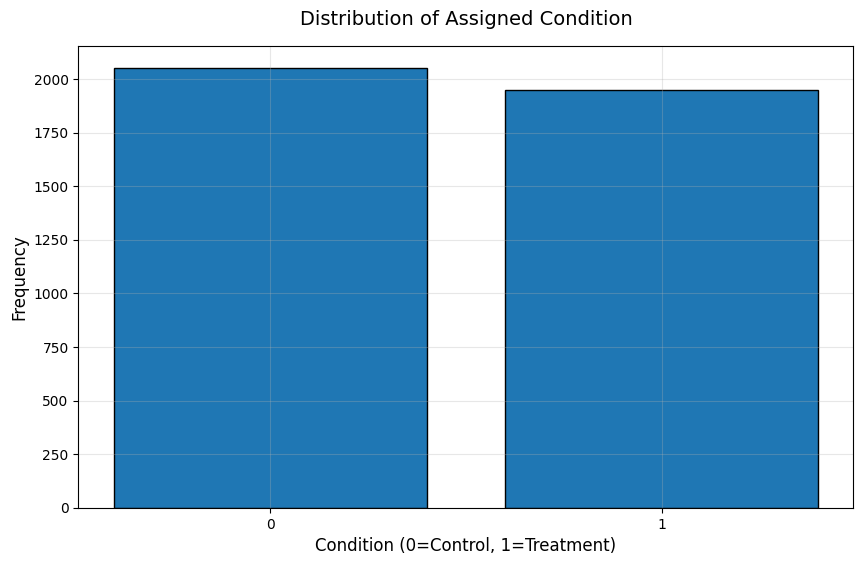

In [57]:
# Confirm 50/50 split
plt.figure(figsize=(10, 6))
plt.bar(['0', '1'], 
        pizza_data['condition'].value_counts().sort_index(),
        edgecolor='black')
plt.title('Distribution of Assigned Condition', fontsize=14, pad=15)
plt.xlabel('Condition (0=Control, 1=Treatment)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)

# Numerical Features

In [58]:
# Run loop to see all numerical features by outcome
def plot_numerical_by_condition(data, numeric_cols):
    """
    Plot numerical distributions by condition and calculate effect sizes
    """
    from scipy import stats
    
    def cohens_d(group1, group2):
        """Calculate Cohen's d effect size"""
        n1, n2 = len(group1), len(group2)
        var1, var2 = group1.var(), group2.var()
        
        # Pooled standard deviation
        pooled_se = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
        
        # Cohen's d
        return (group1.mean() - group2.mean()) / pooled_se
    
    def eta_squared(group1, group2):
        """Calculate eta-squared effect size"""
        # Calculate sum of squares between groups
        grand_mean = np.mean(np.concatenate([group1, group2]))
        ss_between = (len(group1) * (np.mean(group1) - grand_mean)**2 + 
                     len(group2) * (np.mean(group2) - grand_mean)**2)
        
        # Calculate total sum of squares
        ss_total = np.sum((group1 - grand_mean)**2) + np.sum((group2 - grand_mean)**2)
        
        return ss_between / ss_total
    
    # Loop through each numerical column
    for col in numeric_cols:
        # Create figure
        plt.figure(figsize=(12, 6))
        
        # Get data for each condition
        control_data = data[data['condition'] == 0][col]
        treatment_data = data[data['condition'] == 1][col]
        
        # Create histogram
        plt.hist([control_data, treatment_data],
                label=['Control (0)', 'Treatment (1)'],
                bins=50,
                alpha=0.7,
                edgecolor='black')
        
        # Add labels and title
        plt.title(f'Distribution of {col} by Condition', fontsize=14, pad=15)
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Calculate effect sizes
        d = cohens_d(control_data, treatment_data)
        eta_sq = eta_squared(control_data, treatment_data)
        
        # Add summary statistics
        for condition, data_group in zip([0, 1], [control_data, treatment_data]):
            stats_desc = data_group.describe()
            stats_text = (
                f'Condition {condition}:\n'
                f'n: {stats_desc["count"]:.0f}\n'
                f'Mean: {stats_desc["mean"]:.2f}\n'
                f'Median: {stats_desc["50%"]:.2f}\n'
                f'Std: {stats_desc["std"]:.2f}'
            )
            plt.text(0.95 if condition else 0.05, 0.95,
                    stats_text,
                    transform=plt.gca().transAxes,
                    verticalalignment='top',
                    horizontalalignment='right' if condition else 'left',
                    bbox=dict(boxstyle='round',
                             facecolor='white',
                             alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
        # Statistical tests and effect sizes
        t_stat, p_val = stats.ttest_ind(control_data, treatment_data)
        
        print(f"\nResults for {col}:")
        print("-" * 50)
        print(f"T-test results:")
        print(f"t-statistic: {t_stat:.4f}")
        print(f"p-value: {p_val:.4f}")
        
        print("\nEffect Sizes:")
        print(f"Cohen's d: {d:.4f}")
        print(f"Eta-squared: {eta_sq:.4f}")
        
        # Effect size interpretation
        print("\nEffect Size Interpretation:")
        # Cohen's d interpretation
        if abs(d) < 0.2:
            print("Cohen's d: Negligible effect")
        elif abs(d) < 0.5:
            print("Cohen's d: Small effect")
        elif abs(d) < 0.8:
            print("Cohen's d: Medium effect")
        else:
            print("Cohen's d: Large effect")
            
        # Eta-squared interpretation
        if eta_sq < 0.01:
            print("Eta-squared: Negligible effect")
        elif eta_sq < 0.06:
            print("Eta-squared: Small effect")
        elif eta_sq < 0.14:
            print("Eta-squared: Medium effect")
        else:
            print("Eta-squared: Large effect")
        
        print("-" * 50)


## Number of Items

### Customers in the treatment condition who placed orders had statistically significant higher number of items on average than customers who placed orders in the control condition.

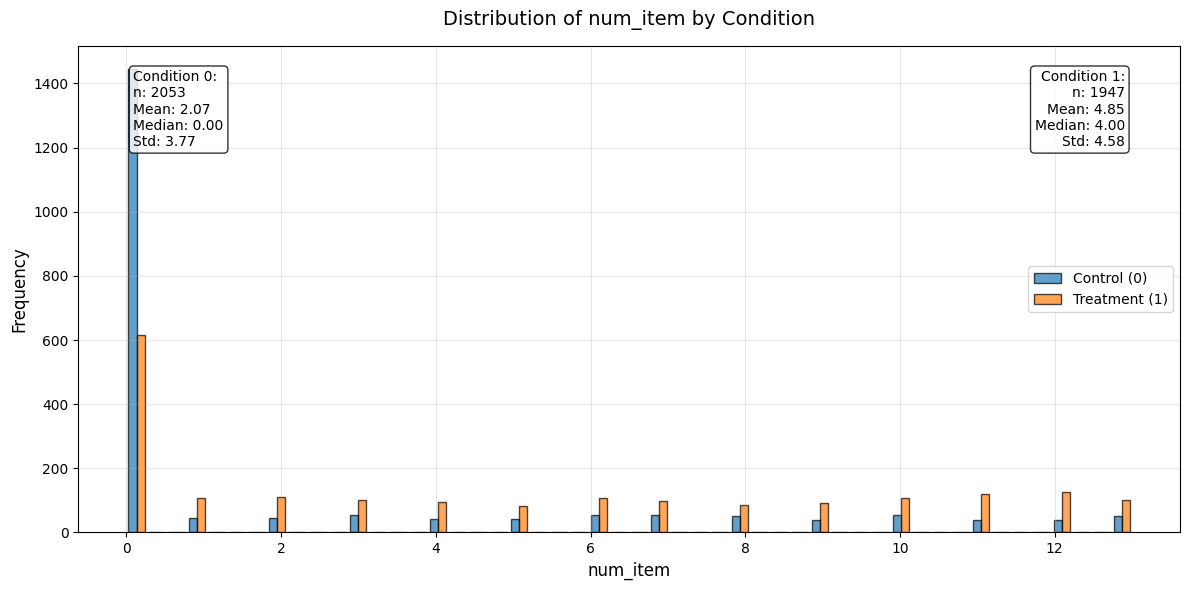


Results for num_item:
--------------------------------------------------
T-test results:
t-statistic: -21.0210
p-value: 0.0000

Effect Sizes:
Cohen's d: -0.6650
Eta-squared: 0.0995

Effect Size Interpretation:
Cohen's d: Medium effect
Eta-squared: Medium effect
--------------------------------------------------


In [59]:
numeric_columns = ["num_item"]
plot_numerical_by_condition(pizza_data, numeric_columns)

## Order Total

### Customers in the treatment condition who placed orders had statistically significant higher order totals on average than customers who placed orders in the control condition.

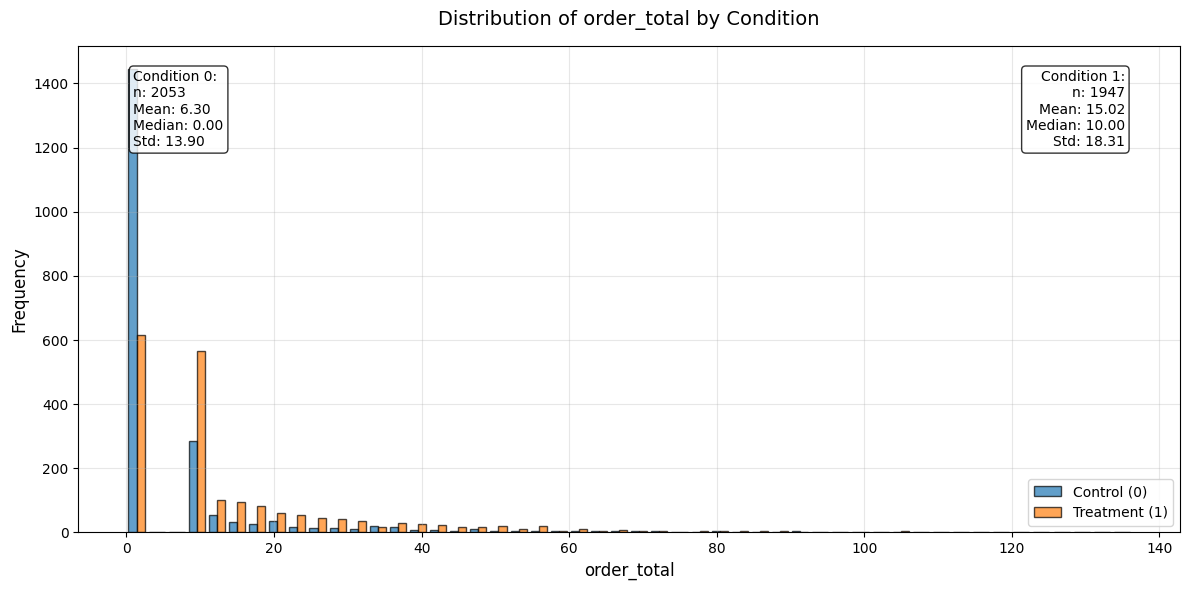


Results for order_total:
--------------------------------------------------
T-test results:
t-statistic: -17.0261
p-value: 0.0000

Effect Sizes:
Cohen's d: -0.5386
Eta-squared: 0.0676

Effect Size Interpretation:
Cohen's d: Medium effect
Eta-squared: Medium effect
--------------------------------------------------


In [60]:
numeric_columns = ["order_total"]
plot_numerical_by_condition(pizza_data, numeric_columns)

## Site Navigation Time

### Customers in the treatment condition spent a statistically significant lower amount of time on average navigating the site compared to customers in the control condition.

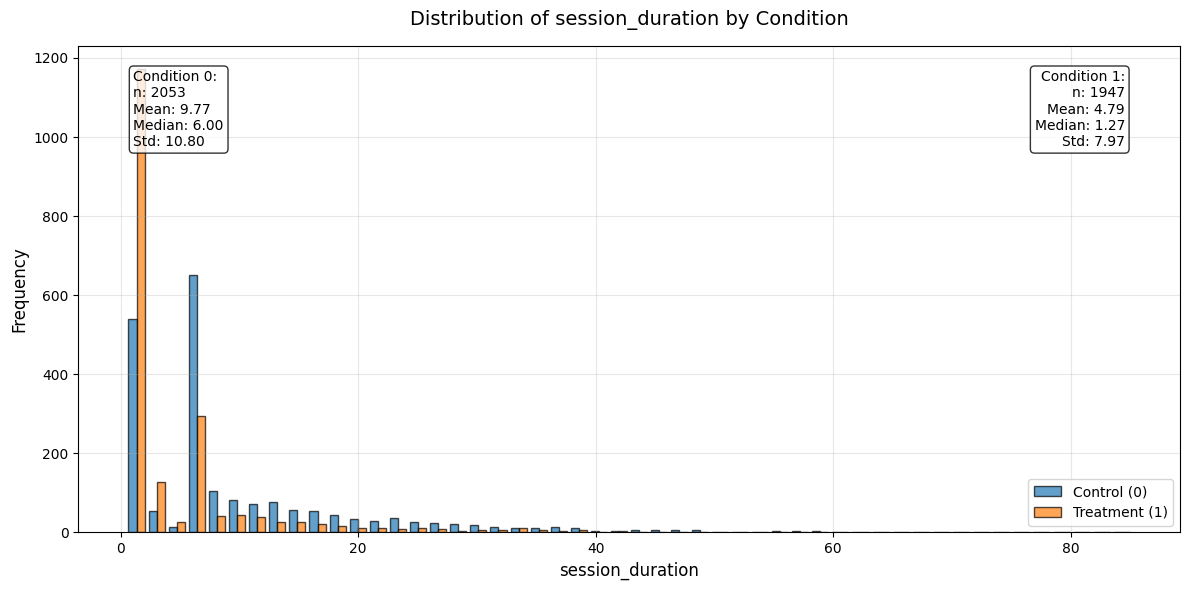


Results for session_duration:
--------------------------------------------------
T-test results:
t-statistic: 16.5053
p-value: 0.0000

Effect Sizes:
Cohen's d: 0.5221
Eta-squared: 0.0638

Effect Size Interpretation:
Cohen's d: Medium effect
Eta-squared: Medium effect
--------------------------------------------------


In [61]:
numeric_columns = ["session_duration"]
plot_numerical_by_condition(pizza_data, numeric_columns)

# Sale Conversion Rate

### Customers in the experimental condition were significantly more likely to make a purchase compared to treatment condition.

In [62]:
# Perform chi-square test with effect sizes
def chi_square_analysis(data, var1='condition', var2='order_conv'):
    """
    Perform chi-square test with effect size calculations
    """
    # Create contingency table
    contingency = pd.crosstab(data[var1], data[var2])
    
    # Perform chi-square test
    chi2, p_value, dof, expected = chi2_contingency(contingency)
    
    # Calculate effect sizes
    n = contingency.sum().sum()  # total observations
    
    # Cramer's V
    min_dim = min(contingency.shape) - 1
    cramer_v = np.sqrt(chi2 / (n * min_dim))
    
    # Phi coefficient (for 2x2 tables)
    phi = np.sqrt(chi2 / n) if contingency.shape == (2, 2) else None
    
    # Print results
    print("Chi-square Test Results")
    print("-" * 50)
    
    print("\nContingency Table:")
    print(contingency)
    
    print("\nTest Statistics:")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Degrees of freedom: {dof}")
    
    print("\nEffect Sizes:")
    print(f"Cramer's V: {cramer_v:.4f}")
    if phi is not None:
        print(f"Phi coefficient: {phi:.4f}")
    
    # Effect size interpretation
    print("\nEffect Size Interpretation:")
    
    # Cramer's V interpretation
    print("Cramer's V:", end=" ")
    if cramer_v < 0.1:
        print("Negligible effect")
    elif cramer_v < 0.3:
        print("Small effect")
    elif cramer_v < 0.5:
        print("Medium effect")
    else:
        print("Large effect")
    
    # Phi interpretation (for 2x2 tables)
    if phi is not None:
        print("Phi coefficient:", end=" ")
        if abs(phi) < 0.1:
            print("Negligible effect")
        elif abs(phi) < 0.3:
            print("Small effect")
        elif abs(phi) < 0.5:
            print("Medium effect")
        else:
            print("Large effect")
    
    # Statistical significance interpretation
    print("\nSignificance:")
    if p_value < 0.05:
        print("Statistically significant (p < 0.05)")
    else:
        print("Not statistically significant (p >= 0.05)")
    
    return {
        'chi2': chi2,
        'p_value': p_value,
        'dof': dof,
        'cramer_v': cramer_v,
        'phi': phi,
        'contingency': contingency
    }

# Run the analysis
results = chi_square_analysis(pizza_data)

Chi-square Test Results
--------------------------------------------------

Contingency Table:
order_conv   0.0   1.0
condition             
0           1445   608
1            617  1330

Test Statistics:
Chi-square statistic: 597.5288
p-value: 0.0000
Degrees of freedom: 1

Effect Sizes:
Cramer's V: 0.3865
Phi coefficient: 0.3865

Effect Size Interpretation:
Cramer's V: Medium effect
Phi coefficient: Medium effect

Significance:
Statistically significant (p < 0.05)


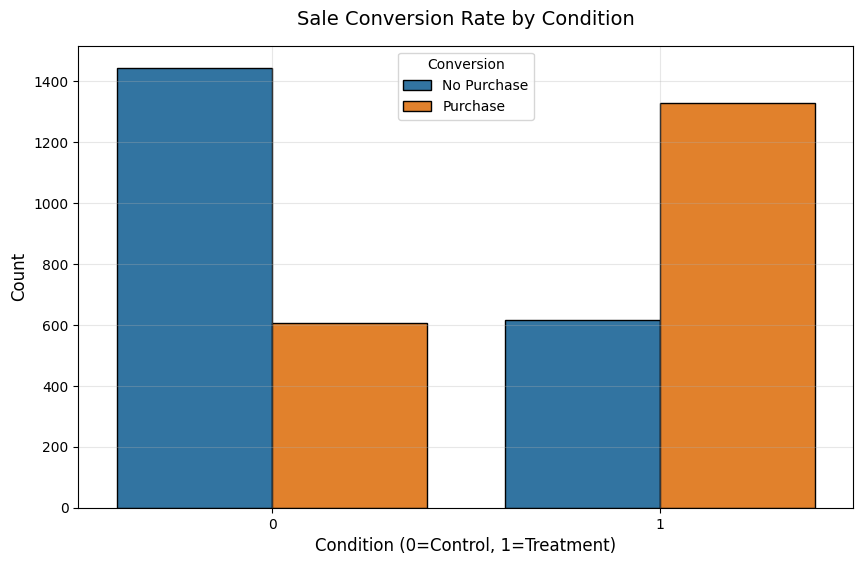

In [63]:
# Site condition by order status
plt.figure(figsize=(10, 6))
sns.countplot(data=pizza_data, 
              x='condition', 
              hue='order_conv',
              edgecolor='black')

plt.title('Sale Conversion Rate by Condition', fontsize=14, pad=15)
plt.xlabel('Condition (0=Control, 1=Treatment)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Conversion', labels=['No Purchase', 'Purchase'])
plt.grid(True, alpha=0.3)
plt.show()